In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# # importing dataset
# dir = os.listdir('../input/plant-village/PlantVillage')
# for filenames in dir:
#     print(filenames)

In [3]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Early_blight ./Potato___Early_blight
!cp -rf ../input/plant-village/PlantVillage/Potato___Late_blight ./Potato___Late_blight
!cp -rf ../input/plant-village/PlantVillage/Potato___healthy ./Potato___healthy

In [4]:
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path(Current_Dir)
print(dataset_dir)

/kaggle/working


In [5]:
Image_size=256
Batch_size=32
Channels=3
Epochs=32

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir, batch_size=Batch_size, image_size=(Image_size, Image_size), shuffle=True)

Found 2152 files belonging to 4 classes.


In [7]:
len(dataset)

68

In [8]:
class_names=dataset.class_names


In [9]:
os.listdir('/kaggle/working/')

['Potato___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 '.virtual_documents']

In [10]:
class_names

['.virtual_documents',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [11]:
type(dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [12]:
for i in dataset:
    print(i)
    break

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[192., 191., 199.],
         [189., 188., 196.],
         [185., 184., 192.],
         ...,
         [177., 175., 186.],
         [176., 174., 185.],
         [176., 174., 185.]],

        [[193., 192., 200.],
         [188., 187., 195.],
         [184., 183., 191.],
         ...,
         [181., 179., 190.],
         [179., 177., 188.],
         [179., 177., 188.]],

        [[192., 191., 199.],
         [189., 188., 196.],
         [186., 185., 193.],
         ...,
         [183., 181., 192.],
         [182., 180., 191.],
         [182., 180., 191.]],

        ...,

        [[168., 165., 172.],
         [172., 169., 176.],
         [168., 165., 172.],
         ...,
         [153., 150., 161.],
         [151., 147., 161.],
         [141., 137., 151.]],

        [[165., 162., 169.],
         [166., 163., 170.],
         [155., 152., 159.],
         ...,
         [152., 149., 160.],
         [144., 140., 154.],
       

In [13]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

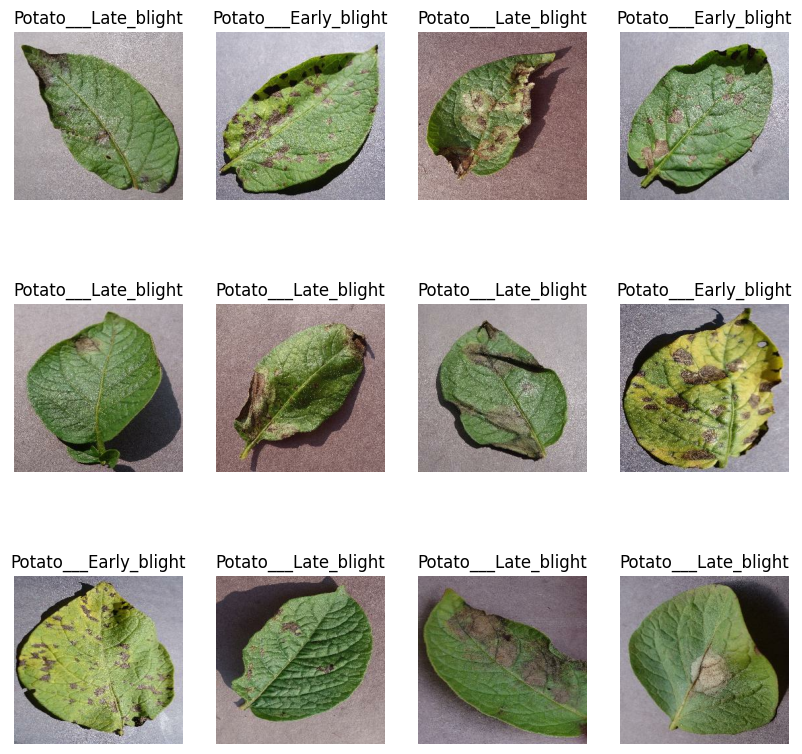

In [14]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
 for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')
#     print(image_batch.shape)
#     print(label_batch.numpy())

In [15]:
len(dataset)

68

80%-->Training
20%-->10% validation,10% test

In [16]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [17]:
train_ds=dataset.take(108)
len(train_ds)

68

In [18]:
test_ds=dataset.skip(108)
len(test_ds)

0

In [19]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [20]:
val_ds=dataset.take(14)
len(val_ds)

14

In [21]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=10)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [22]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [23]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [24]:
train_ds=train_ds.cache().shuffle(789).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(789).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(789).prefetch(buffer_size=tf.data.AUTOTUNE)


In [25]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [26]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.4)
])

In [27]:
input_shape=(Batch_size,Image_size,Image_size,Channels)
model=models.Sequential(
[
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(40,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(62,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(62,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(62,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(62,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(62,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(62,activation='relu'),
    layers.Dense(4,activation='softmax')
])
model.build(input_shape=input_shape)

In [28]:

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 40)        1120      
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 40)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 62)        22382     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 62)          0         
 g2D)                                                 

In [29]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)


**By setting verbose 0, 1 or 2 you just say how do you want to 'see' the training progress for each epoch.**

verbose=0 will show you nothing (silent)

verbose=1 will show you an animated progress bar like this:

progress_bar

verbose=2 will just mention the number of epoch like this:

enter image description here

In [ ]:

history=model.fit(
    train_ds,
    epochs=Epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/32
54/54 [==============================] - 16s 108ms/step - loss: 0.9158 - accuracy: 0.5158 - val_loss: 0.7962 - val_accuracy: 0.6250
Epoch 2/32
54/54 [==============================] - 4s 68ms/step - loss: 0.6864 - accuracy: 0.7124 - val_loss: 0.4851 - val_accuracy: 0.8281
Epoch 3/32
54/54 [==============================] - 4s 68ms/step - loss: 0.4892 - accuracy: 0.7817 - val_loss: 0.2844 - val_accuracy: 0.8906
Epoch 4/32
54/54 [==============================] - 4s 68ms/step - loss: 0.3151 - accuracy: 0.8750 - val_loss: 0.1993 - val_accuracy: 0.9323
Epoch 5/32
54/54 [==============================] - 4s 68ms/step - loss: 0.2438 - accuracy: 0.9002 - val_loss: 0.2463 - val_accuracy: 0.9219
Epoch 6/32
54/54 [==============================] - 4s 68ms/step - loss: 0.2257 - accuracy: 0.9090 - val_loss: 0.1150 - val_accuracy: 0.9635
Epoch 7/32
54/54 [==============================] - 4s 68ms/step - loss: 0.1655 - accuracy: 0.9331 - val_loss: 0.2039 - val_accuracy: 0.9167
Epoch 8/32


In [ ]:
scores=model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history['loss']

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [ ]:
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.plot(range(Epochs),acc,label='Training Accuracy')
plt.plot(range(Epochs),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



plt.subplot(1,2,2)
plt.plot(range(Epochs),loss,label='Training Loss')
plt.plot(range(Epochs),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')



In [ ]:
import pickle
pickle.dump(new_df,open('plants.pkl','wb'))
from google.colab import files
files.download('plants.pkl')